# Ensemble Learning - Visualization
## Hard Voting & Stacking Classifiers

Notebook này visualize quá trình train và kết quả của 2 ensemble models:
- **Hard Voting**: Majority voting từ 4 base models
- **Stacking**: Meta-classifier học từ predictions của base models

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Thêm path để import modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'models')))

from Ensemble import HardVotingClassifier, StackingClassifier

# Cấu hình
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

TRAIN_FILE = '../../data/IRIS_train.csv'
TEST_FILE = '../../data/IRIS_test.csv'

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data và Khởi tạo Models

In [28]:
# Load data
print("Loading data...")
hard_voting = HardVotingClassifier()
X_train, y_train, X_test, y_test = hard_voting.load_data(TRAIN_FILE, TEST_FILE)

print(f"\nData shape:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  Classes: {hard_voting.CLASS_ORDER}")

Loading data...
[OK] Loaded softmax
[OK] Loaded knn
[OK] Loaded decision_tree
[OK] Loaded naive_bayes

=== Đã load 4 pre-trained models ===

Train: 120 samples | Test: 30 samples

Data shape:
  X_train: (120, 4)
  X_test: (30, 4)
  Classes: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']


## 2. Hard Voting - Voting Patterns

In [29]:
# Lấy predictions từ từng base model
X_test_df = pd.DataFrame(X_test, columns=hard_voting.FEATURE_COLS)
X_test_df[hard_voting.LABEL_COL] = hard_voting.CLASS_ORDER[0]

base_predictions = {}
for name, estimator in hard_voting.estimators:
    if name == 'knn':
        preds = estimator.predict(X_test_df)
    elif name == 'softmax':
        pred_indices = estimator.predict(X_test)
        preds = [hard_voting._index_to_label(idx) for idx in pred_indices]
    else:
        preds = list(estimator.predict(X_test))
    base_predictions[name] = preds

# Hard voting ensemble prediction
hv_predictions = hard_voting.predict(X_test)
hv_acc = np.mean(np.array(hv_predictions) == np.array(y_test))

print(f"Hard Voting Accuracy: {hv_acc*100:.2f}%")
print(f"\nBase Model Accuracies:")
for name, preds in base_predictions.items():
    acc = np.mean(np.array(preds) == np.array(y_test))
    print(f"  {name:15s}: {acc*100:.2f}%")

Hard Voting Accuracy: 93.33%

Base Model Accuracies:
  softmax        : 93.33%
  knn            : 93.33%
  decision_tree  : 96.67%
  naive_bayes    : 96.67%


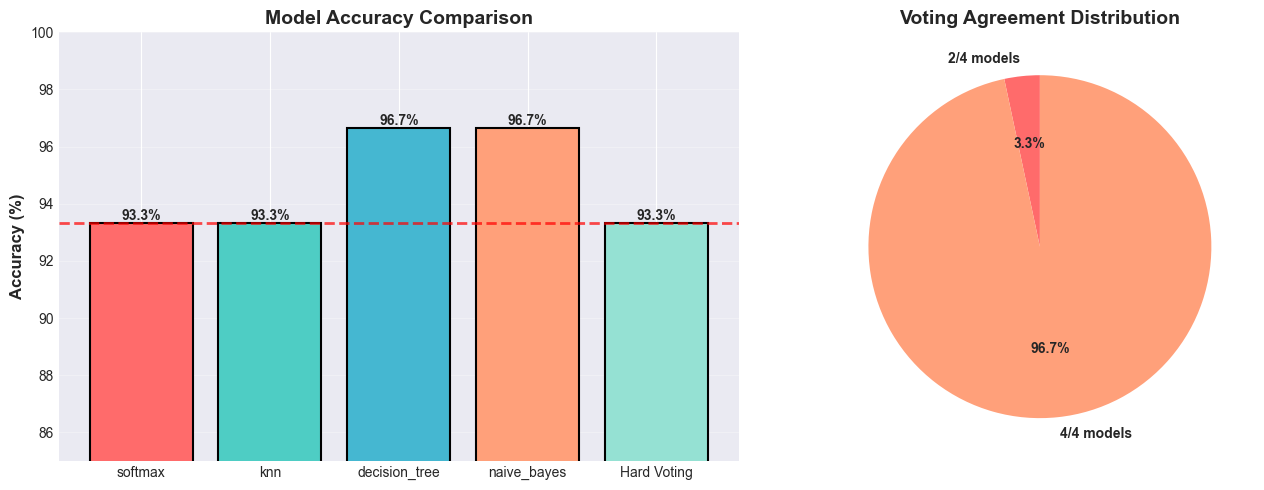


Voting Agreement:
  2/4 models agree: 1 samples (3.3%)
  4/4 models agree: 29 samples (96.7%)


In [30]:
# Visualize: Model Agreement vs Accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Accuracy comparison
model_names = list(base_predictions.keys()) + ['Hard Voting']
accuracies = [np.mean(np.array(preds) == np.array(y_test))*100 for preds in base_predictions.values()] + [hv_acc*100]

bars = axes[0].bar(model_names, accuracies, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#95E1D3'], edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([85, 100])
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(y=hv_acc*100, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Ensemble')

# Thêm giá trị lên bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# Right: Voting patterns (agreement between models)
agreements = []
for i in range(len(X_test)):
    votes = [base_predictions[name][i] for name in base_predictions.keys()]
    # Count max agreement
    vote_counts = {}
    for v in votes:
        vote_counts[v] = vote_counts.get(v, 0) + 1
    max_agreement = max(vote_counts.values())
    agreements.append(max_agreement)

agreement_counts = pd.Series(agreements).value_counts().sort_index()
colors_pie = ['#FF6B6B', '#FFA07A', '#95E1D3', '#4ECDC4']
axes[1].pie(agreement_counts.values, labels=[f'{k}/4 models' for k in agreement_counts.index], 
           autopct='%1.1f%%', startangle=90, colors=colors_pie, textprops={'fontweight': 'bold'})
axes[1].set_title('Voting Agreement Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nVoting Agreement:")
for k, v in agreement_counts.items():
    print(f"  {k}/4 models agree: {v} samples ({v/len(X_test)*100:.1f}%)")

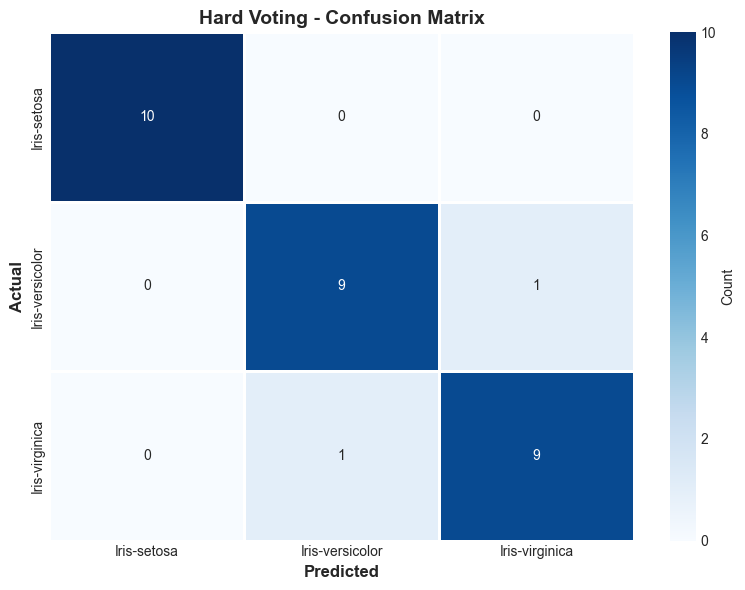


Classification Report (Hard Voting):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      0.90      0.90        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30



In [31]:
# Confusion Matrix for Hard Voting
from sklearn.metrics import confusion_matrix

cm_hv = confusion_matrix(y_test, hv_predictions, labels=hard_voting.CLASS_ORDER)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_hv, annot=True, fmt='d', cmap='Blues', xticklabels=hard_voting.CLASS_ORDER, 
            yticklabels=hard_voting.CLASS_ORDER, cbar_kws={'label': 'Count'}, linewidths=2, linecolor='white')
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title('Hard Voting - Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report (Hard Voting):")
print(classification_report(y_test, hv_predictions, target_names=hard_voting.CLASS_ORDER))

## 3. Stacking - Training Process Visualization

In [32]:
# Train Stacking với tracking loss
stacking = StackingClassifier(use_probas=True)

# Modified fit_meta to track loss
print("Training Stacking meta-classifier...")
meta_features = stacking._create_meta_features(X_train)

# One-hot encode labels
n_samples = len(y_train)
n_classes = len(stacking.CLASS_ORDER)
y_onehot = np.zeros((n_samples, n_classes))
for i, label in enumerate(y_train):
    y_onehot[i, stacking._label_to_index(label)] = 1.0

# Train với tracking
n_features = meta_features.shape[1]
stacking.meta_weights = np.zeros((n_features, n_classes))
stacking.meta_bias = np.zeros((1, n_classes))

learning_rate = 0.1
epochs = 200
losses = []
train_accs = []
test_accs = []

for epoch in range(epochs):
    # Forward
    z = np.dot(meta_features, stacking.meta_weights) + stacking.meta_bias
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    y_hat = exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    # Cross-entropy loss
    loss = -np.mean(np.sum(y_onehot * np.log(y_hat + 1e-10), axis=1))
    losses.append(loss)
    
    # Train accuracy
    train_pred = np.argmax(y_hat, axis=1)
    y_train_indices = np.array([stacking._label_to_index(label) for label in y_train])
    train_acc = np.mean(train_pred == y_train_indices)
    train_accs.append(train_acc)
    
    # Test accuracy
    meta_features_test = stacking._create_meta_features(X_test)
    z_test = np.dot(meta_features_test, stacking.meta_weights) + stacking.meta_bias
    exp_z_test = np.exp(z_test - np.max(z_test, axis=1, keepdims=True))
    y_hat_test = exp_z_test / np.sum(exp_z_test, axis=1, keepdims=True)
    test_pred = np.argmax(y_hat_test, axis=1)
    y_test_indices = np.array([stacking._label_to_index(label) for label in y_test])
    test_acc = np.mean(test_pred == y_test_indices)
    test_accs.append(test_acc)
    
    # Gradient
    error = y_hat - y_onehot
    dW = (1/n_samples) * np.dot(meta_features.T, error)
    db = (1/n_samples) * np.sum(error, axis=0)
    
    # Update
    stacking.meta_weights -= learning_rate * dW
    stacking.meta_bias -= learning_rate * db
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Train Acc: {train_acc*100:.2f}% - Test Acc: {test_acc*100:.2f}%")

print(f"\nTraining completed!")
print(f"Final Test Accuracy: {test_accs[-1]*100:.2f}%")

[OK] Loaded softmax
[OK] Loaded knn
[OK] Loaded decision_tree
[OK] Loaded naive_bayes

=== Đã load 4 pre-trained models ===

Training Stacking meta-classifier...
Epoch 50/200 - Loss: 0.1507 - Train Acc: 100.00% - Test Acc: 96.67%
Epoch 100/200 - Loss: 0.0735 - Train Acc: 100.00% - Test Acc: 96.67%
Epoch 150/200 - Loss: 0.0485 - Train Acc: 100.00% - Test Acc: 96.67%
Epoch 200/200 - Loss: 0.0362 - Train Acc: 100.00% - Test Acc: 96.67%

Training completed!
Final Test Accuracy: 96.67%


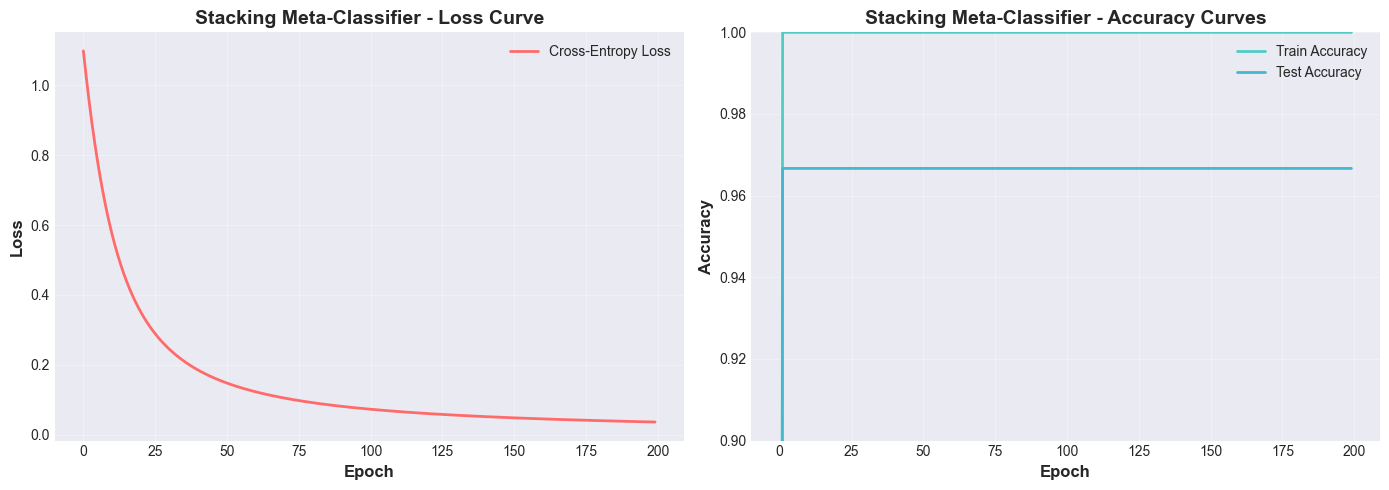

In [33]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(losses, color='#FF6B6B', linewidth=2, label='Cross-Entropy Loss')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Stacking Meta-Classifier - Loss Curve', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

# Accuracy curves
axes[1].plot(train_accs, color='#4ECDC4', linewidth=2, label='Train Accuracy')
axes[1].plot(test_accs, color='#45B7D1', linewidth=2, label='Test Accuracy')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Stacking Meta-Classifier - Accuracy Curves', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)
axes[1].set_ylim([0.9, 1.0])

plt.tight_layout()
plt.show()

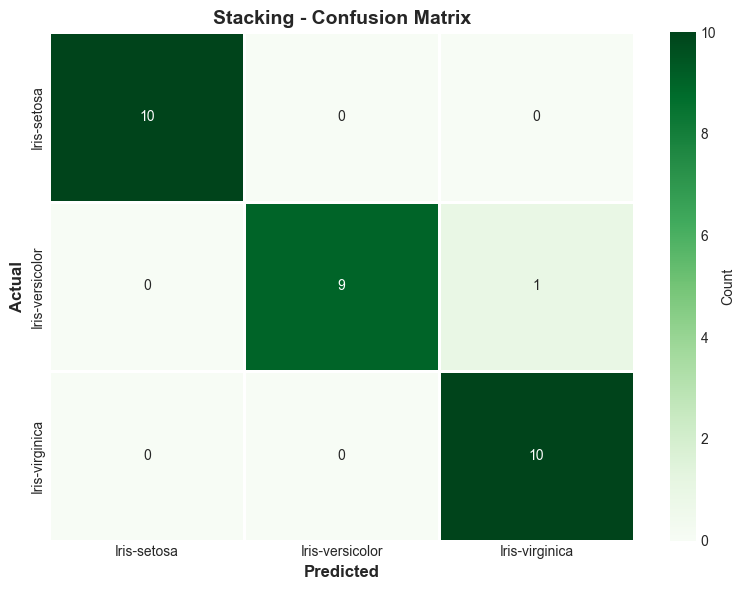


Stacking Accuracy: 96.67%

Classification Report (Stacking):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



In [34]:
# Stacking predictions và confusion matrix
st_predictions = stacking.predict(X_test)
st_acc = np.mean(np.array(st_predictions) == np.array(y_test))

cm_st = confusion_matrix(y_test, st_predictions, labels=stacking.CLASS_ORDER)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_st, annot=True, fmt='d', cmap='Greens', xticklabels=stacking.CLASS_ORDER, 
            yticklabels=stacking.CLASS_ORDER, cbar_kws={'label': 'Count'}, linewidths=2, linecolor='white')
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title('Stacking - Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nStacking Accuracy: {st_acc*100:.2f}%")
print("\nClassification Report (Stacking):")
print(classification_report(y_test, st_predictions, target_names=stacking.CLASS_ORDER))

## 4. Meta-Features Analysis (Stacking)

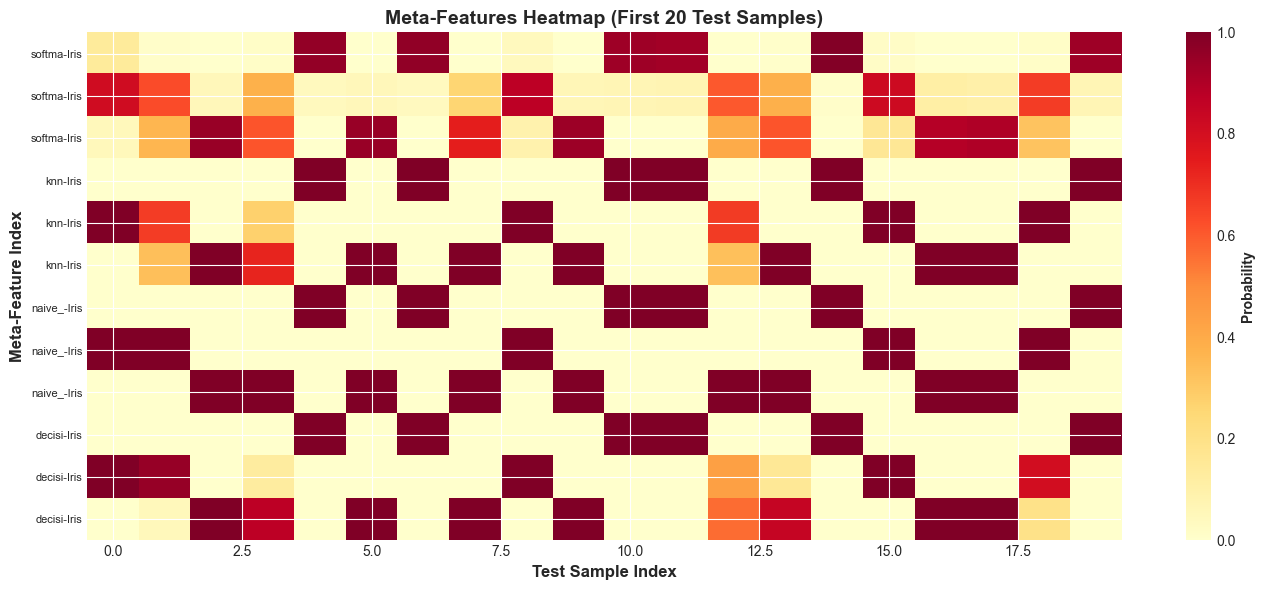

Meta-features shape: (20, 12)
  - 4 base models
  - 3 classes each
  - Total: 12 features


In [35]:
# Visualize meta-features (probabilities from base models)
meta_features_viz = stacking._create_meta_features(X_test[:20])  # First 20 samples

fig, ax = plt.subplots(figsize=(14, 6))
im = ax.imshow(meta_features_viz.T, cmap='YlOrRd', aspect='auto')

# Labels
ax.set_xlabel('Test Sample Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Meta-Feature Index', fontsize=12, fontweight='bold')
ax.set_title('Meta-Features Heatmap (First 20 Test Samples)', fontsize=14, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Probability', fontsize=10, fontweight='bold')

# Add model labels on y-axis
model_labels = []
for name in ['softmax', 'knn', 'naive_bayes', 'decision_tree']:
    for cls in stacking.CLASS_ORDER:
        model_labels.append(f"{name[:6]}-{cls[:4]}")

ax.set_yticks(range(len(model_labels)))
ax.set_yticklabels(model_labels, fontsize=8)

plt.tight_layout()
plt.show()

print(f"Meta-features shape: {meta_features_viz.shape}")
print(f"  - {len(stacking.estimators)} base models")
print(f"  - {len(stacking.CLASS_ORDER)} classes each")
print(f"  - Total: {len(stacking.estimators) * len(stacking.CLASS_ORDER)} features")

## 5. Final Comparison

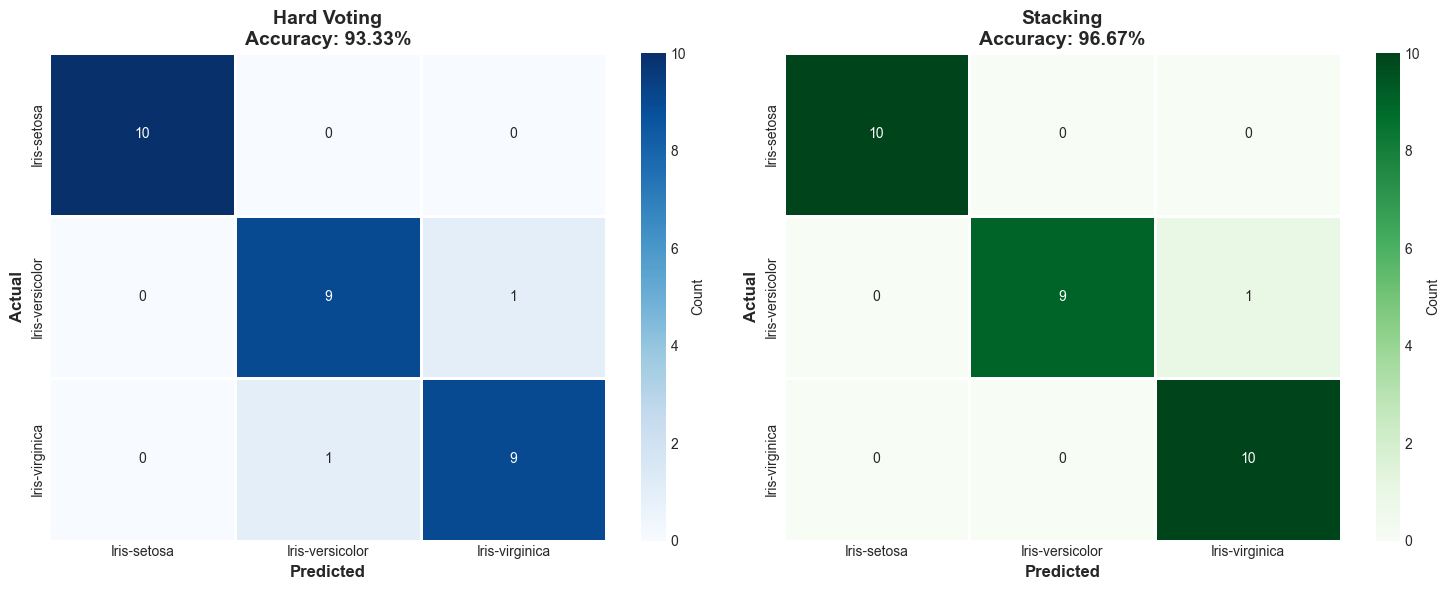

In [36]:
# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Hard Voting
sns.heatmap(cm_hv, annot=True, fmt='d', cmap='Blues', xticklabels=hard_voting.CLASS_ORDER, 
            yticklabels=hard_voting.CLASS_ORDER, ax=axes[0], cbar_kws={'label': 'Count'}, 
            linewidths=2, linecolor='white')
axes[0].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[0].set_title(f'Hard Voting\nAccuracy: {hv_acc*100:.2f}%', fontsize=14, fontweight='bold')

# Stacking
sns.heatmap(cm_st, annot=True, fmt='d', cmap='Greens', xticklabels=stacking.CLASS_ORDER, 
            yticklabels=stacking.CLASS_ORDER, ax=axes[1], cbar_kws={'label': 'Count'}, 
            linewidths=2, linecolor='white')
axes[1].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[1].set_title(f'Stacking\nAccuracy: {st_acc*100:.2f}%', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

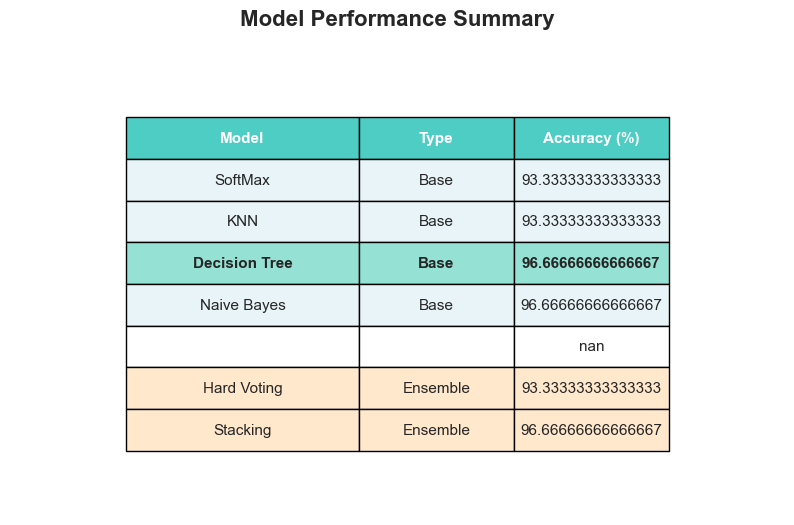


SUMMARY
Best Base Model: Decision Tree (96.67%)
Best Ensemble Model: Stacking (96.67%)

Improvement: 0.00%


In [37]:
# Summary comparison table
summary_data = {
    'Model': ['SoftMax', 'KNN', 'Decision Tree', 'Naive Bayes', '', 'Hard Voting', 'Stacking'],
    'Type': ['Base', 'Base', 'Base', 'Base', '', 'Ensemble', 'Ensemble'],
    'Accuracy (%)': [
        np.mean(np.array(base_predictions['softmax']) == np.array(y_test))*100,
        np.mean(np.array(base_predictions['knn']) == np.array(y_test))*100,
        np.mean(np.array(base_predictions['decision_tree']) == np.array(y_test))*100,
        np.mean(np.array(base_predictions['naive_bayes']) == np.array(y_test))*100,
        np.nan,
        hv_acc*100,
        st_acc*100
    ]
}

df_summary = pd.DataFrame(summary_data)

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=df_summary.values, colLabels=df_summary.columns, 
                cellLoc='center', loc='center', colWidths=[0.3, 0.2, 0.2])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header
for i in range(len(df_summary.columns)):
    table[(0, i)].set_facecolor('#4ECDC4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style base models
for i in range(1, 5):
    for j in range(len(df_summary.columns)):
        table[(i, j)].set_facecolor('#E8F4F8')

# Style ensemble models
for i in [6, 7]:
    for j in range(len(df_summary.columns)):
        table[(i, j)].set_facecolor('#FFE8CC')

# Highlight best
best_idx = df_summary['Accuracy (%)'].idxmax() + 1
for j in range(len(df_summary.columns)):
    table[(best_idx, j)].set_facecolor('#95E1D3')
    table[(best_idx, j)].set_text_props(weight='bold')

plt.title('Model Performance Summary', fontsize=16, fontweight='bold', pad=20)
plt.show()

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Best Base Model: {df_summary.loc[df_summary.iloc[:4]['Accuracy (%)'].idxmax(), 'Model']} "
      f"({df_summary['Accuracy (%)'].iloc[:4].max():.2f}%)")
print(f"Best Ensemble Model: {df_summary.loc[df_summary.iloc[5:]['Accuracy (%)'].idxmax(), 'Model']} "
      f"({df_summary['Accuracy (%)'].iloc[5:].max():.2f}%)")
print(f"\nImprovement: {(df_summary['Accuracy (%)'].iloc[5:].max() - df_summary['Accuracy (%)'].iloc[:4].max()):.2f}%")
print("="*60)

## 6. Save Ensemble Models

In [38]:
# Save models
print("Saving ensemble models...")
hard_voting.save_model('../models/hard_voting_ensemble.pkl')
stacking.save_model('../models/stacking_ensemble.pkl')

print("\nModels saved successfully!")
print(f"  - Hard Voting: ../models/hard_voting_ensemble.pkl")
print(f"  - Stacking: ../models/stacking_ensemble.pkl")

Saving ensemble models...
Model saved to ../models/hard_voting_ensemble.pkl
Model saved to ../models/stacking_ensemble.pkl

Models saved successfully!
  - Hard Voting: ../models/hard_voting_ensemble.pkl
  - Stacking: ../models/stacking_ensemble.pkl
